

# The Objective

Build a predictive model that will produce the highest profit for the next direct marketing campaign, scheduled for the next month.

The new campaign, sixth, aims at selling a new gadget to the Customer Database. 

To build the model, a pilot campaign involving 2.240 customers was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled.

The total cost of the sample campaign was 6.720MU and the revenue
generated by the customers who accepted the offer was 3.674MU. Globally the campaign had a profit of -3.046MU.

The success rate of the campaign was 15%.

The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base.

Hopefully the model will allow the company to cherry pick the customers that are most likely to purchase the offer while leaving out the non-respondents, making the next campaign highly profitable. 

Moreover, other than maximizing the profit of the campaign, the CMO is interested in understanding to study the characteristic features of those customers who are willing to buy the gadget.


# Key objectives

1. Explore the data: Provide better understanding of the characteristic features of respondents

2. Propose and describe a customer segmentation based on customer behaviors

3. Create a predictive model which allows the company to maximize the profit of the next marketing campaign

4. Whatever else is necessary

# Deliverables

1. Data exploration
2. Segmentation
3. Classification model
4. A short business presentation






# The dataset

5 categories:

* wine
* rare meat
* exotic fruit
* specially prepared fish
* sweet products

2 types:

* regular
* gold

3 sales channels:

* physical stores
* catalog
* company website


## Features

* AcceptCmp[1,2,3,4,5] : Accepted campaing 1 to 5
* Response (target): Accepted offer in the 5th campaing
* Complain: 1 if complained in the last 2 years
* DtCustomer: Date of enrollment with the company
* Education: Customer's level of education
* Marital: marita status, categorical (8, 5 main ones)
* Income: yearly house income
* Kidhome: number of young children in customer's home 
* Teenhome: number of teenagers in customer's home
* MntFishProducts: Ammount of money spent in fish products on the last 2 years
* MntMeatProducts: Ammount of money spent in meat on the last 2 years
* MntFruits: Ammount of money spent on fruit in the last 2 years
* MntSweetProducts: Ammount of money spent on sweets in the last 2 years
* MntWines: Ammount of money spent on wines in the last 2 years
* MntGoldProds:  Ammount of money spent on gold products in the last 2 years
* NumDealsPurchases: number of purchases made with discount
* NumCatPurchases:  number of purchases made with catalog
* NumStorePurchases:  number of purchases made in stores
* NumWebPurchases:  number of purchases made on the website
* NumWebVisitsMonth:  number of visits to the website in the last month
* Recency: number of days since last purchase




# Import modules and data

In [114]:
import pandas as pd
import seaborn as sns
import numpy as np
import profile

from matplotlib import pyplot as plt
df = pd.read_csv("./ml_project1_data.csv",parse_dates=["Dt_Customer"])
#df.columns =  df.columns.str.lower()
#assuming this research was carried out in 2019

# 1. Eploratory data analysis

First we check column types and create some attributes that may be useful later

In [115]:
df.dtypes

ID                              int64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Z_CostContac

* `Age` represents the age of the respondent (we assume this research was carried out in 2014, since the most recent `DT_customer` value is from `2014-06-29`
* `HasKid` is a dummy variable with 1 if a person has at least one kid, 0 otherwise
* `HasTeen` is a dummy variable with 1 if a person has at least one teen, 0 otherwise
* `HasSibling` summarizes info from `HasKid` and `HasTeen` 

In [116]:
df["Age"] = 2015 - df.Year_Birth
df["HasKid"] = df.Kidhome > 0
df["HasTeen"] = df.Teenhome > 0
df["HasSibling"] = df.HasKid | df.HasTeen


## 1.1 Missing data

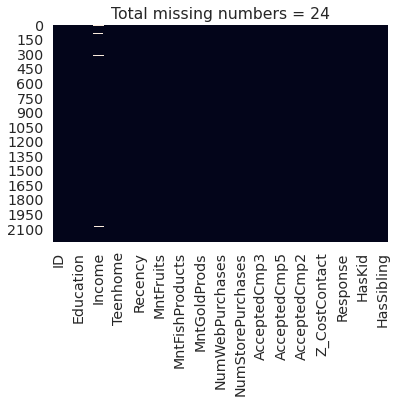

In [117]:
plt.title(f"Total missing numbers = {df.isna().sum().sum()}")
sns.heatmap(df.isnull(), cbar=False)
plt.show()

There are only a few observations missing `Income` data.

## 1.2 Sample acceptance per campaign

In [118]:
pd.melt(df[[c for c in df.columns if "Accepted" in c] + ["Response"]],
          var_name = "campaign",value_name="accepted").groupby("campaign").accepted\
          .value_counts(normalize=True)

campaign      accepted
AcceptedCmp1  0           0.935714
              1           0.064286
AcceptedCmp2  0           0.986607
              1           0.013393
AcceptedCmp3  0           0.927232
              1           0.072768
AcceptedCmp4  0           0.925446
              1           0.074554
AcceptedCmp5  0           0.927232
              1           0.072768
Response      0           0.850893
              1           0.149107
Name: accepted, dtype: float64

The 2nd campaign acceptance rate from the sample was around 5 times less than the others (aprox. 1.3% acceptance rate vs 6.5-7.5% from others). 
This can be a bias from the sample or the second campaing was conducted differently than the others.

The 6th campaign was already two times more efficient than the others, for the sampled respondents.


### Acceptance rate per groups

Initially, we can explore the acceptance per different groups of categorical variables, to get some insights. Below I present a claim and a code chunk supporting the claim.

In [119]:
def get_acceptance_rate_per_cat(df,categories):
    acceptance_cols = [c for c in df.columns if "Accept" in c]
    group_cols = categories
    size_info = df[group_cols + acceptance_cols + ["Response"]].\
                    groupby(group_cols).agg("size")
    size_info.name="Size"
    accept_rate = df[group_cols + acceptance_cols + ["Response"]].\
                groupby(group_cols).agg(["mean"])

    accept_rate = pd.concat([accept_rate.droplevel(1,axis=1),
                             size_info],axis=1).dropna().\
                             sort_values("Response",ascending=False)
    accept_rate["Absolute"] = (accept_rate.Size * accept_rate.Response).astype(int)
    return accept_rate

1.**`Education`:** People with higher education to have higher `Response` acceptance rate for the sample

In [120]:
get_acceptance_rate_per_cat(df,["Education"]).sort_values(["Absolute","Response"],ascending=False)\
    [["Response","Size","Absolute"]]

,Response,Size,Absolute
Education,,,
Graduation,0.134871,1127,152
PhD,0.207819,486,101
Master,0.154054,370,57
2n Cycle,0.108374,203,22
Basic,0.037037,54,2


2.**`Marital_Status`**: The categories `Single`, `Divorced` and `Widow`, had both a higher acceptance rate and absolute numbers than `Together` and `Married` for the last campaign.

In [121]:
get_acceptance_rate_per_cat(df,["Marital_Status"]).sort_values(["Absolute","Response"],ascending=False)\
    [["Response","Size","Absolute"]]

,Response,Size,Absolute
Marital_Status,,,
Single,0.220833,480,106
Married,0.113426,864,98
Together,0.103448,580,60
Divorced,0.206897,232,48
Widow,0.246753,77,19
Absurd,0.500000,2,1
YOLO,0.500000,2,1
Alone,0.333333,3,1


3.**`Complain`**: Even though a few people complained (less than 1%), this did not seem to affect the response rate 

In [122]:
get_acceptance_rate_per_cat(df,["Complain"]).sort_values(["Absolute","Response"],ascending=False)\
    [["Response","Size","Absolute"]]

,Response,Size,Absolute
Complain,,,
0,0.149166,2219,331
1,0.142857,21,3


In [123]:
print("number of clients that accepted at least one campaign")
num_at_least_1 = df[[c for c in df.columns if "Accepted" in c]].any(axis=1).sum()
print(num_at_least_1,f"({round(num_at_least_1/df.shape[0]*100,1)}%)")

number of clients that accepted at least one campaign
463 (20.7%)


4.**`Year_Registration`**: Based on the year of registration, we see that the longer the respondent is a customer, the more likely that he or she will accept the answer

In [124]:
df["Year_Registration"] = df.Dt_Customer.dt.year
get_acceptance_rate_per_cat(df,["Year_Registration"]).sort_values(["Absolute","Response"],ascending=False)\
    [["Response","Size","Absolute"]]

,Response,Size,Absolute
Year_Registration,,,
2013,0.129521,1189,154
2012,0.267206,494,132
2014,0.086176,557,48


## 1. 3`Age` and `Year_Birth`

We can also check numerical data min, max, mean, and quantiles for first insights.

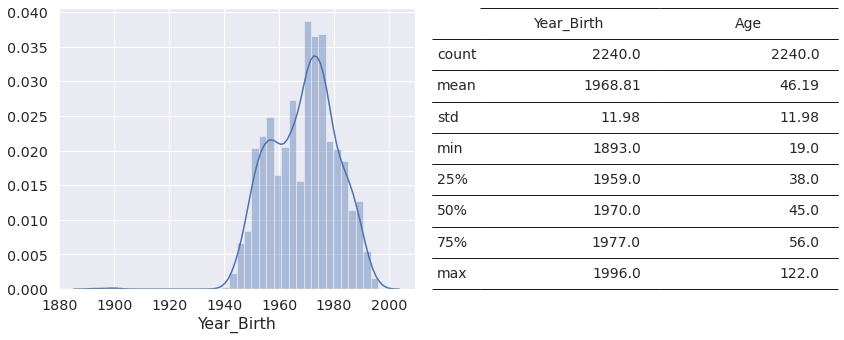

In [125]:
import matplotlib.pyplot as plt
#from matplotlib import six
import pandas as pd
import numpy as np

year_age_describe = df[["Year_Birth","Age"]].describe().round(2)

fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.distplot(df.Year_Birth,ax=ax[0])

font_size=14
bbox=[0, 0, 1, 1]
ax[1].axis('off')
mpl_table = ax[1].table(cellText = year_age_describe.values, rowLabels = year_age_describe.index, bbox=bbox,
                        colLabels=year_age_describe.columns, edges='BT')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.tight_layout()

With an average age of 46 and more than 75% of the sample consisting of people with more than 38 years, most of the respondents are probably less open to innovative products. 
If the gadget consists of a new electronic or something that is somewhat out of the ordinary, we can expect a low response rate.
On the other hand, if the gadget targets an older population, this would be adequate.

Either way, the age of the respondents should be considered. Though further study is necessary, the age of the respondents might have played a role in the higher acceptance rate in this 6th campaign, in relation to others.
 

**\*** *Even though `Age` is an attribute I built on the assumption that the year of the research was 2015, most of the conclusions may hold, for 75% of the sample was born before 1977, so the age of the respondents might have biased the sample.
There were three respondents born before 1940 (in 1893, 1899 and 1900) and the next oldest one was born on 1940. In a more detailed study, the veracity of this information should be checked.*

## 1.4 `Income`

In [126]:
print(df.Income.describe())

# fig, ax = plt.subplots(1,2,figsize=(12,5))
# df.Income.plot(kind="box",ax=ax[0])
# df.Income.loc[df.Income < 666666].plot(kind="box",ax=ax[1])
# plt.show()
print("Number of respondents with more than 120000 yearly salary:",
     (df.Income > 120000).sum())

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64
Number of respondents with more than 120000 yearly salary: 8


We can se that there is one outlier in the sample who has a really above average year
ly income.
Supressing it from the sample's distribution plot allows us to have a better sense of income distribution.


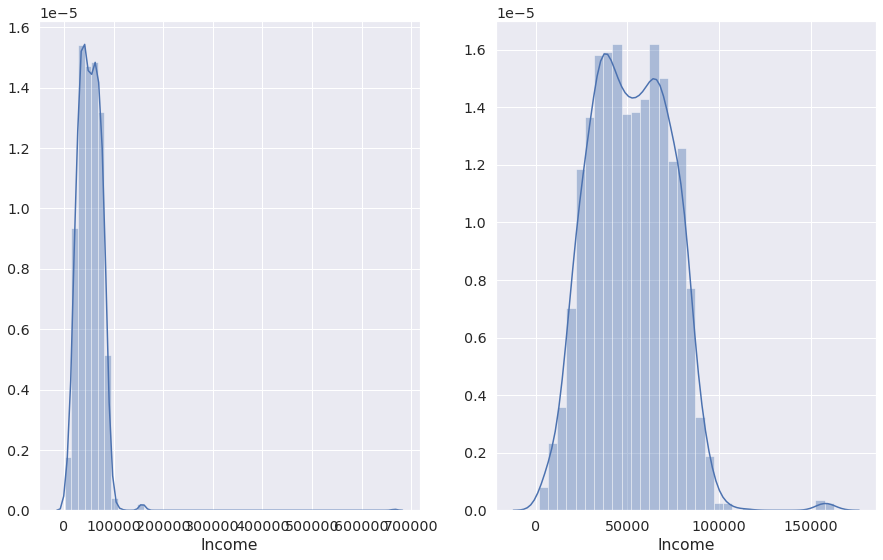

In [127]:
fig,ax=plt.subplots(1,2,figsize=(15,9))
sns.distplot(df.Income,ax=ax[0])
sns.distplot(df.Income.loc[df.Income < 666666],ax=ax[1])
plt.show()

The sample `Income` distribution seems to be bimodal, with more than 50% of the respondents receiveing more than less than 35k and less than 70k per year. It is a wide range of salary,

## 1.5 `Mnt` and prefered `channel` per category

We segment ammount spent on each type of product (`Mnt`) and preferred channel (`channel`) by different categories to get some initial insights on respondents behavior per category.

First, we create a few more categorical data columns:
* `CatIncome` splits `Income` in 4 quantiles (less than 1st quantile, between 1st and median, between median and 3rd and greater than 3rd)
* `CatAge` splits age in 4 quantiles using the same logic as above
* `ReducedMarital` converts the categories `Alone`, `Absurd`and `YOLO` to the category `Other`, because of the few observations with the original values 

In [128]:
df["CatIncome"] = pd.qcut(round(df.Income,1),q=4,labels=range(1,5))
df["CatAge"] = pd.qcut(df.Age,q=4,labels=range(1,5))
reduce_marital = {"Alone":"Other","Absurd":"Other","YOLO":"Other"}

df["ReducedMarital"] = df.Marital_Status.replace(reduce_marital)

The dataframe below is used to generate the graphs that follow.
After each graph, I present some conclusions based on observed data. 
They can be useful for hypothesis testing and some initial insights, but true conclusions would need further sampling and investigation

In [129]:
category = ["CatIncome"]
mnt_cols = ['MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts']
df[mnt_cols + category].groupby(category).mean().apply(lambda x: x/x.sum(),axis=1)*100

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts
CatIncome,,,,,
1,33.286865,9.167201,35.009898,13.385563,9.150473
2,61.420946,3.950723,23.736311,6.685497,4.206525
3,62.826706,4.386375,23.041829,5.658989,4.086101
4,49.383992,4.729772,33.919827,6.903530,5.062879


In this table we have the income category in rows and the percent spend of the total ammount spent on which product type for each category. Each row's columns sum to 100%. We can see from the data that, for example, people from income categories 1,2 and 3 tend to spend most of their income on wine products while people from income category 0, split almost equally into wine and meat and are also the ones who spend the most (proportionally) on fish.

In the graphs below, the color represents the percentages above

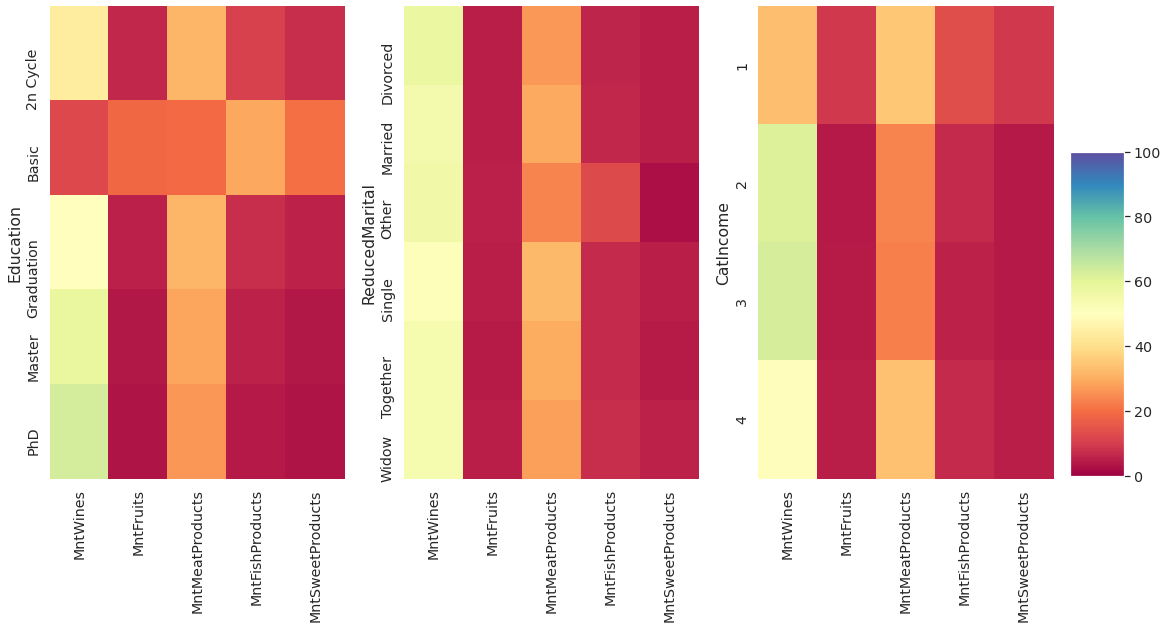

In [130]:
sns.set(font_scale=1.3)

categories = ["Education","ReducedMarital","CatIncome"]
fig,ax = plt.subplots(1,3,figsize=(15,9))

for i,cat in enumerate(categories):
    category = [cat] 
    percent_per_cat = df[mnt_cols + category].groupby(category).mean().apply(lambda x: x/x.sum(),axis=1)*100
    sns.heatmap(percent_per_cat,
                ax=ax[i],cmap="Spectral",vmin=0,vmax=100,cbar=False)
im = ax[0].get_children()[0]
fig.tight_layout()
#fig.colorbar(im,shrink=0.5)

# put colorbar at desired position
cbar_ax = fig.add_axes([1, 0.25, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax,shrink=0.5)
plt.show()

#### Conclusions

* People with basic education tend to spend, on average, more on fish products than people with other education levels
* The higher the education level, the more the respondents spend on Wine products
* Across all categories, fruit, fish and sweets have the least ammount of expenses

## 1.6 `channel` per category

In [131]:
channels = ['NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases']

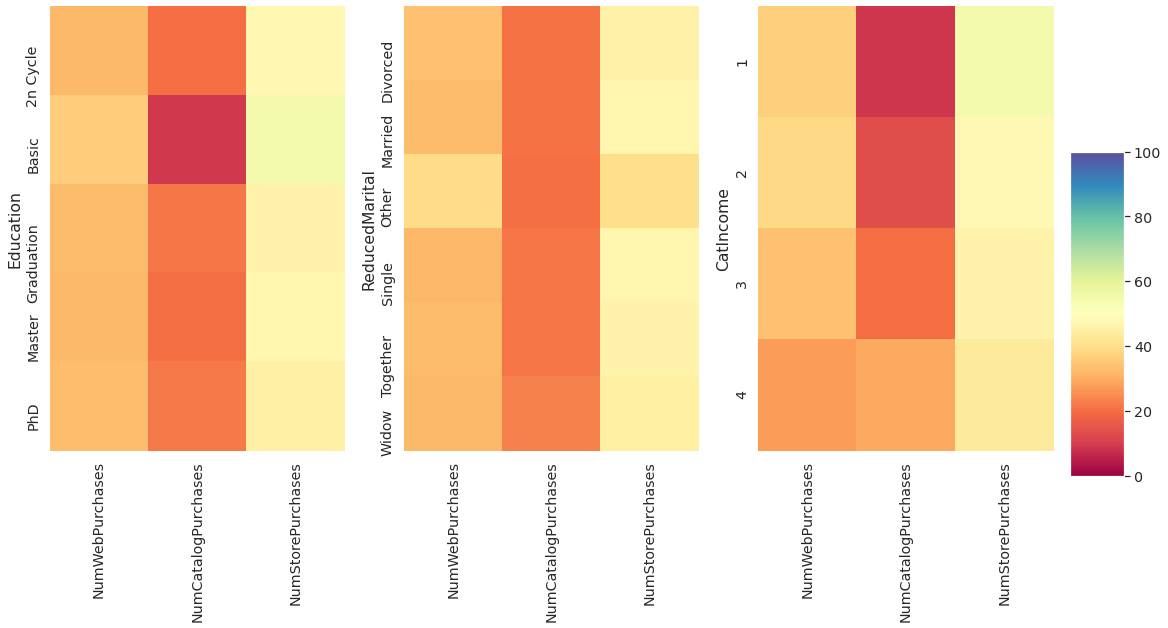

In [132]:
categories = ["Education","ReducedMarital","CatIncome"]
fig,ax = plt.subplots(1,3,figsize=(15,9))

for i,cat in enumerate(categories):
    category = [cat] 
    sns.heatmap(df[channels + category].groupby(category).mean().apply(lambda x: x/x.sum(),axis=1)*100,
                ax=ax[i],cmap="Spectral",vmin=0,vmax=100,cbar=False)
    plt.tight_layout()
im = ax[0].get_children()[0]
fig.tight_layout()
#fig.colorbar(im,shrink=0.5)

# put colorbar at desired position
cbar_ax = fig.add_axes([1, 0.25, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax,shrink=0.5)
plt.show()

#### Conclusions

* Across all categories,  catalog purchases are the least prefered method.
* People with more income, tend to have more catalog purchases
* People with basic education tend to  prefer store purchases



## 1.7  `MntGoldProds` to total spent in the 5 product types

In [133]:
def compare_gold_and_deals(category,df):
    total_mnt = pd.Series(df.groupby([category])[mnt_cols].sum().sum(axis=1),name="TotalMnt").reset_index().set_index(category)
    mnt_table = df.groupby([category])[["MntGoldProds"]].sum()/total_mnt.values
    mnt_table = round(mnt_table*100,2)

    total_mnt = pd.Series(df.groupby([category])[channels].sum().sum(axis=1),name="TotalDeals").reset_index().set_index(category)
    deals_table = df.groupby([category])[["NumDealsPurchases"]].sum()/total_mnt.values
    deals_table = round(deals_table*100,2)

    return pd.concat([mnt_table,deals_table],axis=1)

In [134]:
compare_gold_and_deals("Education",df)

,MntGoldProds,NumDealsPurchases
Education,,
2n Cycle,10.31,19.44
Basic,38.72,34.40
Graduation,8.94,18.21
Master,7.07,19.42
PhD,5.05,17.65


The data above shows the percentage of the total spent on the 5 products that was spent with gold produtcs and the percentage of the total . We see that :
* The higher the education level, the less they spend in gold products. People with `Basic`education seem to spend a significantly more on gold products.
* People with `Basic` education level also make more deal purchases than people with other education level

In [135]:
compare_gold_and_deals("CatIncome",df)

,MntGoldProds,NumDealsPurchases
CatIncome,,
1,26.03,37.83
2,13.82,31.35
3,8.38,18.38
4,5.62,7.32


* People with lower income spend more on gold products and purchase more deals
* People in categories 3 and 4 make less deal purchases in relation to the total of purchases

In [136]:
compare_gold_and_deals("ReducedMarital",df)

,MntGoldProds,NumDealsPurchases
ReducedMarital,,
Divorced,8.20,19.02
Married,7.81,19.04
Other,16.71,27.17
Single,7.77,17.60
Together,7.60,18.60
Widow,8.32,16.27


* In this case only the `Alone`, `Aburd` and `Yolo`categories seem to have a different spending pattern

## 1.8 Conclusions on EDA

Even though the conclusions presented above would require further study or hypothesis testing to verify their significance, it is useful to have some initial insights on data. It also helps to better understand the dataset structure and will make it easier to interpret model variable importance outputs.

# 2. Client segmentation

In this section we will use the Recency, Frequency, Monetary Value approach to do client segmentation.
Here, the company wants clients to buy frequently (low recency), buy a lot (high number of purchases, i.e. high frequency) and spend a lot (high monetary value). 

## Recency

Given the apparenty uniform recency distribution, there was no strong bias towards sampling recent more recent customers only. All custumers drawn have made at least one purchase in the last 100 days.

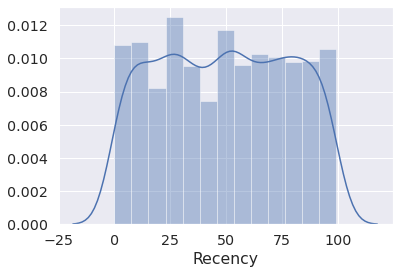

In [137]:
sns.distplot(df.Recency)

## Frequency

In [138]:
channels = ['NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',]
df["Frequency"] = df[channels].sum(axis=1)

freq_descript = pd.DataFrame(df.Frequency.describe()).round(2)

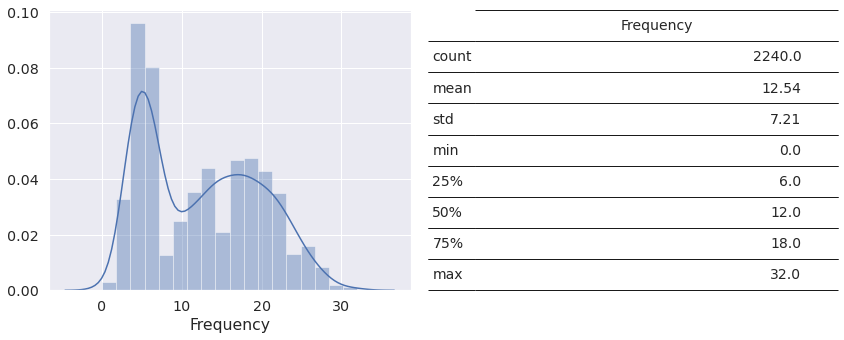

In [139]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.distplot(df.Frequency,ax=ax[0])

font_size=14
bbox=[0, 0, 1, 1]
ax[1].axis('off')
mpl_table = ax[1].table(cellText = freq_descript.values, rowLabels = freq_descript.index, bbox=bbox,
                        colLabels=freq_descript.columns, edges='BT')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.tight_layout()

The sample's ammount of purchases has a lot of clients in the 5 purchases range and also a considerable amount of clients on the 15-22 purchases in the last 2 years

# Monetary Value

In [140]:
monetary = ['MntWines',
           'MntFruits',
           'MntMeatProducts',
           'MntFishProducts',
           'MntSweetProducts']

df["Monetary"] = df[monetary].sum(axis=1) 
monetary_descript = pd.DataFrame(df.Monetary.describe()).round(2)

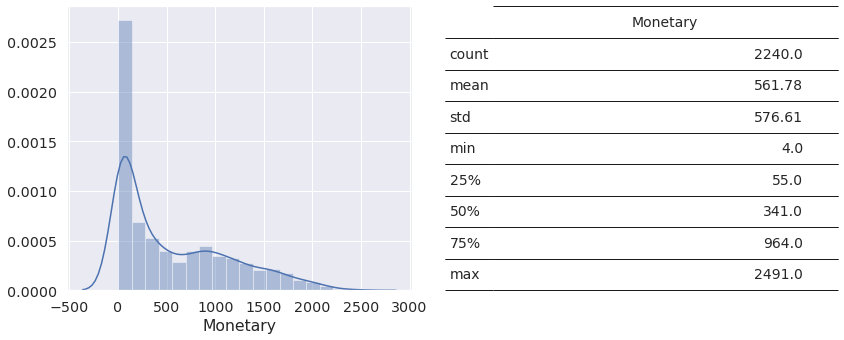

In [141]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.distplot(df.Monetary,ax=ax[0])

font_size=14
bbox=[0, 0, 1, 1]
ax[1].axis('off')
mpl_table = ax[1].table(cellText = monetary_descript.values, rowLabels = monetary_descript.index, bbox=bbox,
                        colLabels=monetary_descript.columns, edges='BT')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.tight_layout()

A lot of clients make small value purchases. Though some clients who spend a lot draw the average purchase value to approximatel 561M.U, about 50% of the clients spent less than 341 M.U. in the past 2 years.

## 2.1 `RFM` segmentation

### 2.1.1 Segmentation using k-means clustering

We can use a k-means algorithm to segment data in clusters regarding their recency, frequency and monetary values.
To do so, we first use the elbow method to identify the ideal ammount of clusters we should use to segment the respondents.

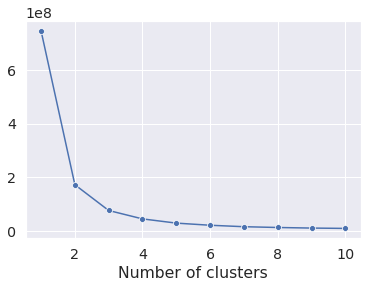

In [142]:
from sklearn.cluster import KMeans

df_cluster = df[["Recency","Frequency","Monetary"]].values

sum_of_squared_dists = []
for i in range(1, 11):
    km = KMeans( n_clusters=i, init='random', n_init=10, max_iter=300,
                 tol=1e-04, random_state=31)
    km.fit(df_cluster)
    sum_of_squared_dists.append(km.inertia_)

# plot
sns.lineplot(range(1, 11), sum_of_squared_dists, marker='o')
plt.xlabel('Number of clusters')
plt.show()

From the graph a greater reduction on the sum of the squared distances is seen when 3 clusters are used, if a higher value is used, the sum of squares does not reduce as much as it did from 2 to 3 clusters.

In [143]:
km = KMeans( n_clusters=3, init='random', n_init=10, max_iter=300,
             tol=1e-04, random_state=31).fit(df_cluster)
labels = pd.Series([x[0] for x in km.labels_.reshape(-1,1)])

df["cluster"] = labels

The column `cluster` assigns each respondent to a cluster based on the results of the columns `Recency`, `Frequency` and `Monetary`.

In [144]:
df.groupby("cluster")[["Recency","Frequency","Monetary"]].mean()

,Recency,Frequency,Monetary
cluster,,,
0,48.835637,7.462366,139.762673
1,51.111111,20.002924,1613.309942
2,48.558725,19.338926,880.295302


### 2.1.2 Segmentation using a score

An alternative approach is to create a category for the numeric variables `Recency`, `Frequency` & `Modeling`. Where higher numeric values are better.
In this case, we have to choose and assume that the number of categories chosen is enough to segment data.

The `k-means` approach has a more quantitative solution using the elbow method.

Below a value from 1 to 4 was assigned to the `Recency`, `Frequency` and `Monetary` columns where higher values mean a better score.

In [145]:
recency_cat = [4,3,2,1]
frequency_cat = [1,2,3,4]
monetary_cat = [1,2,3,4]

df["RecencyScore"] = pd.qcut(df.Recency,q=4,labels=recency_cat)
df["FrequencyScore"] = pd.qcut(df.Frequency,q=4,labels=frequency_cat)
df["MonetaryScore"] = pd.qcut(df.Monetary,q=4,labels=monetary_cat)

Now, the scores are summed and, again, a number of categories (`q`= 3) was chosen to split the sum of scores.

In [146]:
df["Score"] = df[[c for c in df.columns if "Score" in c]].sum(axis=1)

df["FinalScore"] = pd.qcut(df.Score,q=3,labels=["need_focus","make_happier","keep_happy"])

### 2.2 Conclusions

### 2.2.1 K-means

In [147]:
sizes = df.groupby("cluster").size()
sizes.name = "size"
pd.concat([df.groupby("cluster")[["Recency","Frequency","Monetary","Response"]].mean(),
          sizes],axis=1)

,Recency,Frequency,Monetary,Response,size
cluster,,,,,
0,48.835637,7.462366,139.762673,0.098310,1302
1,51.111111,20.002924,1613.309942,0.365497,342
2,48.558725,19.338926,880.295302,0.135906,596


Using the k-means algorithm, we dont see a great difference in recency between clusters, but we do find that clusters 1 and 2 have similar frequency patterns but respondents in cluster 1 spend almost 2 times as much as respondents in cluster 2. 
Also respondents from cluster 0 have a low frequency and low monetary spenditure, and also represent more than 50% of the sample.

In this case, the company would benefit from:
* Developing a strategy to make individuals from cluster 1 return more, as they seem to spend more per purchase
* Developing a strategy to make individ from cluster 2 spend more
* Finding out if there are individuals from cluster 0 with similar characteristics from the other clusters and try to direct advertise to those individuals

### 2.2.2 Score

In [148]:
sizes = df.groupby("FinalScore").size()
sizes.name = "size"
pd.concat([df.groupby("FinalScore")[["Recency","Frequency","Monetary","Response"]].mean(),
          sizes],axis=1)

,Recency,Frequency,Monetary,Response,size
FinalScore,,,,,
need_focus,57.159954,5.570771,75.754891,0.060990,869
make_happier,54.768765,14.817191,684.128329,0.148910,826
keep_happy,27.695413,20.188991,1151.299083,0.289908,545


The score segmentation generated more evenly distributed group sizes.
It also segmented more based on recency.
In this case, most of the conclusions from the `k-means` algorithm results apply and the company should also focus on making individuals from group `need_focus` either spend more or return more.

# 3. Prediction model to increase profit

In this section we'll explore two different prediction techniques that can predict the probability that a given client is going to accept the campaign (`Response` = 1). 

If we manage to getter a better idea of which clients have high probability of accpeting an offer, the company can target individuals who are more likely to accept an offer than not. This may increase the overall profit.

The explored techniques are `logistic regression` and a `xgbboost` model. A logistic regressiong classifier can serve as a initial baseline for modeling since its pretty standard for outputing probabilities and we can also explore variable importance using the regression coefficients. A `xgboost` classifier can, sometimes, pergorm better than a logistic regression and we can also explore variable importances by exploring the `SHAP` values. 

In both cases, we will one-hot encode categorical data and normalize numerical features, this way, all variables will be in the 0-1 range. To compare results, we will use the same training and test data. 

# 3.1 Data preparation

## 3.1.1 Variable selection

Even though we can include different sets of variables, to keep this report shorter and maybe different from others, we will keep the variables created from original columns throghout the analysis. Given more time (and interest) we can easily expand to a comparison between datasets with different engineered features.

Some additional considerations:

* We will fill those 24 missing values of income with the median income
* We will drp `Z_CostConstact` and `Z_Revenue` for both have only constant values
* We will keep only `HasKid` and `HasTeen` as columns with children information, since `HasSibling` is a linear combination of those
* Regarding marital status, we will use the `ReducedMarital` to reduce the number of created columns when one-hot encoding
* to avoid problems with small normalized values, we will drop the one respondent with over 600k year income


In [149]:
personal_info_columns = ['Education', 'Income', 'Year_Registration', 'Age', 'HasKid', 'HasTeen','Recency','Complain','ReducedMarital']
ammount_spent_columns = ['MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']
deal_and_gold_columns = ['MntGoldProds', 'NumDealsPurchases']
channels_info_columns = ['NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
previous_campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
target = ['Response']

In [150]:
model_columns = personal_info_columns +\
                ammount_spent_columns +\
                deal_and_gold_columns +\
                channels_info_columns +\
                previous_campaign_columns +\
                target

In [151]:
df.Income.fillna(df.Income.median(),inplace=True)

In [152]:
df[model_columns].shape

(2240, 26)

Our dataset now has 25 prediction variables and one target variable

In [171]:
model_data = df[model_columns].loc[df.Income < 600000].copy()
model_data["Year_Registration"] = model_data.Year_Registration.astype(str)

### 3.1.2 Split in train and test data

In [ ]:
from sklearn.model_selection import train_test_split
X = model_data.copy()
y = X.pop("Response")

Abaixo, são criadas variáveis dummy com os valores de `Education`, `Year_Registration` e `ReducedMarital`.

In [180]:
columns_to_dummy = ['Education','Year_Registration','ReducedMarital']
X = pd.concat([X[[c for c in X.columns if c not in columns_to_dummy]],
               pd.get_dummies(X[columns_to_dummy])], axis=1)

In [181]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.33,random_state=31)

In [182]:
Xtrain.shape

(1500, 36)

## 3.1.3 Normalize numeric features based on `Xtrain` data

We will use only information from the training set when normalizing features.

In [183]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = ['Age', 'Recency', 'MntWines',"Income",
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
scaler.fit(Xtrain[columns_to_scale])

MinMaxScaler()

In [184]:
normXtrain = pd.DataFrame(scaler.transform(Xtrain[columns_to_scale]),index=Xtrain.index,columns=Xtrain[columns_to_scale].columns)
normXtest = pd.DataFrame(scaler.transform(Xtest[columns_to_scale]),index=Xtest.index,columns=Xtest[columns_to_scale].columns)

In [199]:
Xtrain.loc[:,columns_to_scale] = normXtrain
Xtest.loc[:,columns_to_scale] = normXtest

/home/mferrac/.rzn/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### 3.2 Train and test models

In [436]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import scikitplot 
from xgboost import XGBClassifier

import itertools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [202]:
logreg = LogisticRegression()
xgb = XGBClassifier()

In [203]:
params_logreg = {'penalty' : ['l1', 'l2'],
                 'C' : np.logspace(-4, 4, 10),
                 'solver' : ['liblinear']}

clf_logreg = RandomizedSearchCV(logreg,params_logreg,random_state=31)

search_logreg = clf_logreg.fit(Xtrain,ytrain)

search_logreg.best_params_

In [227]:
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
clf_xgb = RandomizedSearchCV(xgb,params_xgb,random_state=31)

search_xgb = clf_xgb.fit(Xtrain,ytrain)

search_xgb.best_params_

{'subsample': 0.8,
 'min_child_weight': 5,
 'max_depth': 4,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

## 3.3 Compare results

In [230]:
predictions_xgb = clf_xgb.predict_proba(Xtest)
predictions_logreg = clf_logreg.predict_proba(Xtest)

In [319]:
log_reg_importance = pd.DataFrame({"variable" : Xtrain.columns.values, 
              "coefficient" :[x[0] for x in clf_logreg.best_estimator_.coef_.reshape(-1,1)]})

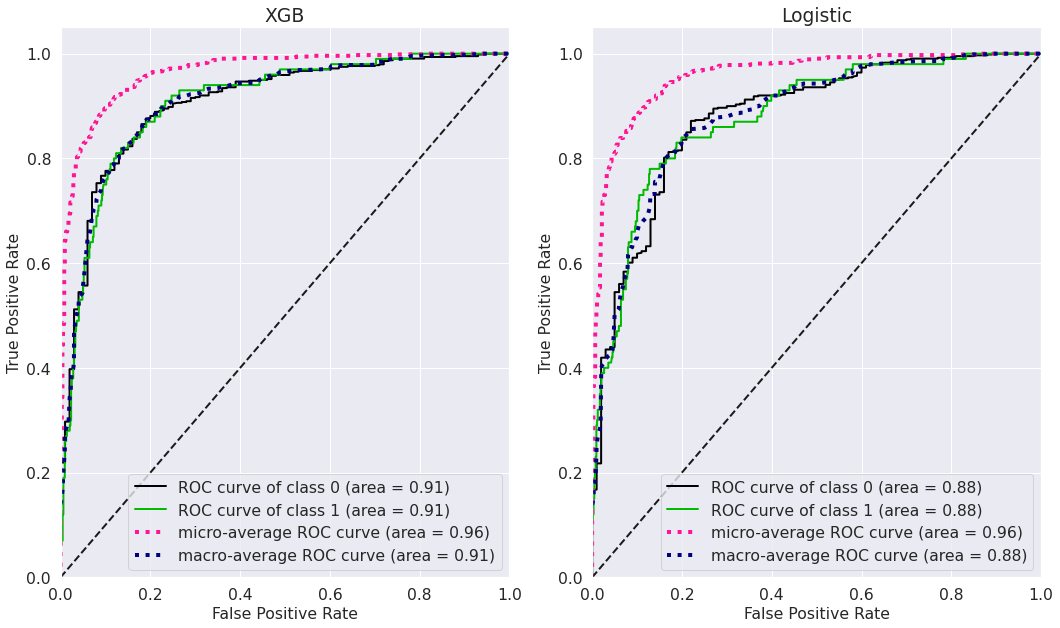

In [427]:
fig,ax=plt.subplots(1,2,figsize=(15,9))

scikitplot.metrics.plot_roc(ytest,predictions_xgb,ax=ax[0],title="XGB")
scikitplot.metrics.plot_roc(ytest,predictions_logreg,ax=ax[1],title="Logistic")
plt.tight_layout()
plt.show()

Both results are very similar and also pretty close to 1, which brings evidence of a good performance. To dig deeper, we can quantify the results selecting a probability threshold and exploring the results.

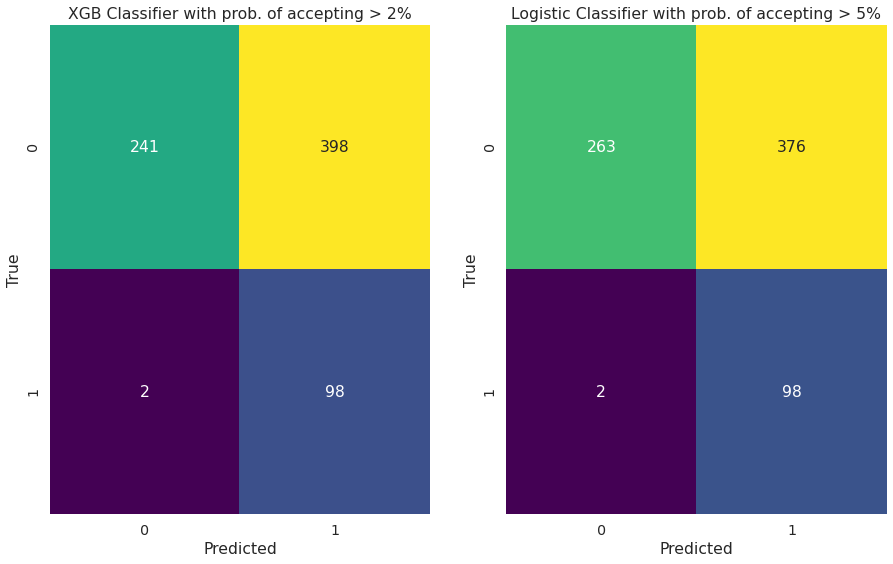

Number of test set respondents: (739, 36)
Number of positive responses in test set : 100


In [429]:
fig,ax=plt.subplots(1,2,figsize=(15,9))

cm = confusion_matrix(ytest,(predictions_xgb[:,1] > 0.02).astype(int))
sns.heatmap(cm,annot=True,cmap="viridis",fmt='g',cbar=False,ax=ax[0])
ax[0].set_ylabel("True")
ax[0].set_xlabel("Predicted")
ax[0].set_title("XGB Classifier with prob. of accepting > 2%")

cm = confusion_matrix(ytest,(predictions_logreg[:,1] > 0.05).astype(int))
sns.heatmap(cm,annot=True,cmap="viridis",fmt='g',cbar=False)
ax[1].set_ylabel("True")
ax[1].set_xlabel("Predicted")
ax[1].set_title("Logistic Classifier with prob. of accepting > 5%")


plt.show()

print("Number of test set respondents:",Xtest.shape)

print("Number of positive responses in test set :",ytest.sum())

This means that for all test observations (739 respondents with 100 possitive responses) if we only called respondants which :

* For the `xgb` classifier had a probability higher than: 2% we would have called (398+98) = 496 respondents with a success rate of (98/(376+98)) ~19.7%, instead of (100/739) ~13.5%
* For the `logistic` classifier had a probability higher than: 5% we would have called (376+98) = 474 respondents with a success rate of (98/(398+98)) ~20.6%, instead of (100/739) ~13.5%

In both cases, we would not have called 2 respondents which would've bougth the gadget.

## 3.4 Variable importance

In [438]:
import shap

explainer = shap.TreeExplainer(clf_xgb.best_estimator_)
shap_values = explainer.shap_values(Xtest)

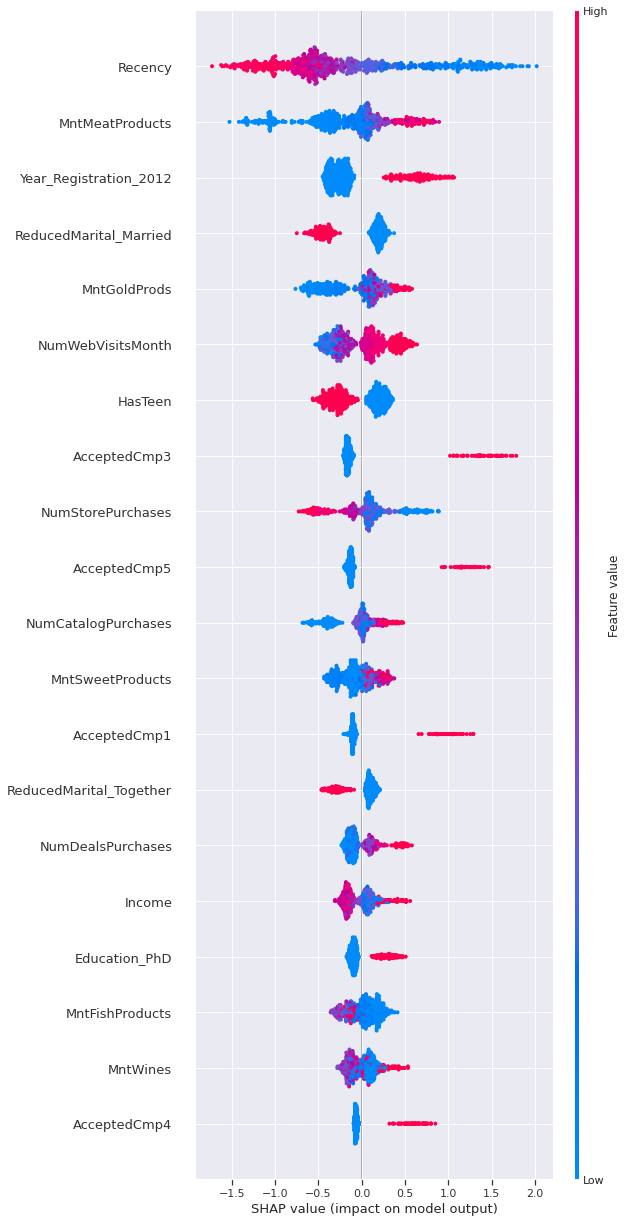

In [439]:
log_reg_table = log_reg_importance.reindex(log_reg_importance.coefficient.abs().\
                                           sort_values(ascending=False).index).round(2).reset_index(drop=True)
shap.summary_plot(shap_values, Xtest,show=False,plot_size=1)



In [396]:
log_reg_table

,variable,coefficient
0,Recency,-2.25
1,AcceptedCmp3,1.80
2,AcceptedCmp5,1.45
3,AcceptedCmp1,1.20
4,NumDealsPurchases,1.11
5,NumStorePurchases,-1.06
6,Year_Registration_2014,-1.02
7,ReducedMarital_Married,-1.01
8,AcceptedCmp4,0.87
9,AcceptedCmp2,0.86


* General similarities for both techniques:
    * High recency means less probability of positive response for both outputs
    * Having accepted previous campaigns has a positive impact on `Response`
    * Being `Married` or `Together` had a negative impact on `Response`
    * `Income`, `Age` and `Complain` had low impact for decision
    * Buying gold or deal products had a positive impact on `Response`
* Regarding date of registration importance, we can draw similar conclusions with different evidence:
    * For the `xgb` classifier, being an customer for a longer time (`Year_Registration_2012`) ranked higher in importance for the positive impact on `Response`
    * For the `logistic` classifier, being a new customer (`Year_Registration_2014`) ranked higher in importance for the negative impact on `Response`
* Regarding products bought:
    * Buying more meat products had a positive impact on `Response`

## 3.5 Conclusions

With the results presented here, we can proceed in two ways:

* Use the model to predict (based on the features used here) the probability of sampled customers buying the product and offer only for those who have probabilities above a chosen threshold:
    * As shown in the previous section, by doing this we can improve the sample response rate, but are subject to  false negatives and their cost.
* Explore the conclusions drawn in section 3.4 regarding variable importance. With this, we can improve sampling of respondents based on characteristics that might indicate a better response. For example, we could sample only for older customers and single individuals and see if we get a better response rate in the next campaing.

In [455]:
gains = 3674
cost = 6720

print("Cost per respondent:",cost/df.shape[0])

print("Revenue per positive response:",gains/df.Response.sum() )

print("Cost of campaing for the 739 teste set respondents:", cost/df.shape[0] * Xtest.shape[0])

print("Total Revenue for the 739 test set respondents:",gains/df.Response.sum() * ytest.sum() )

print("Cost if we called only the 474 test set respondents with probability of buying above 5%:", 474*3)
print("Total Revenue for the 98 of the 474 test positive respondents:", 98*11 )

Cost per respondent: 3.0
Revenue per positive response: 11.0
Cost of campaing for the 739 teste set respondents: 2217.0
Total Revenue for the 739 test set respondents: 1100.0
Cost if we called only the 474 test set respondents with probability of buying above 5%: 1422
Total Revenue for the 98 of the 474 test positive respondents: 1078


If we chose to use the `logistc` model, for the 1st option, the campaing would be much closer to breaking even.